In [63]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../')

import gensim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import graphsemnet.gsn_recursive as gsn
import graphsemnet.semantics as sem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [516]:
sns.set(font_scale=1.5)

# Semantic graph demo

## Building a semantic graph

In [517]:
fruit_adj = np.array(
    [
        [0, .5, .25, .125],
        [.5, 0, .25, .125],
        [.25, .25, 0., .125],
        [.125, .125, .125, 0.]
    ]
)

fruit_labels = ['apple', 'banana', 'coconut', 'durian']

fruit_graph = gsn.SemanticGraph(fruit_adj, fruit_labels)

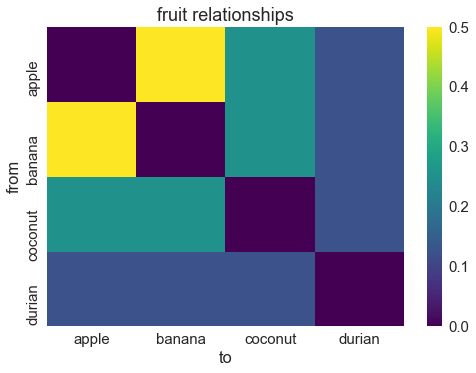

In [518]:
sns.heatmap(
    fruit_graph.adj, 
    xticklabels=fruit_graph.labels, 
    yticklabels=fruit_graph.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('fruit relationships')

## Building a semantic graph from a pre-trained word2vec model

Rather than guessing our fruit relationship weights (because we are probably wrong), let's pull them from a pre-trained semantic model.

In [519]:
google_news_w2v_path = '/Users/beau/Desktop/Projects/Language/language_repo/GoogleNews-vectors-negative300.bin'
google_news = gensim.models.KeyedVectors.load_word2vec_format(google_news_w2v_path, binary=True)

In [520]:
fruit_dsm_w2v = sem.semantic_dsm(['apple', 'banana', 'coconut', 'durian'], google_news)

# Note: now we are using a dissimilarity matrix instead of an adjacency matrix, 
#       so we use the word_dsm argument
fruit_graph_w2v = gsn.SemanticGraph(word_dsm=fruit_dsm_w2v, labels=fruit_labels)

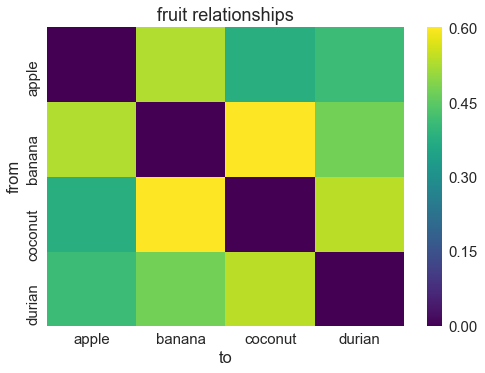

In [521]:
sns.heatmap(
    fruit_graph_w2v.adj, 
    xticklabels=fruit_graph_w2v.labels, 
    yticklabels=fruit_graph_w2v.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('fruit relationships')

## Activating a node changes weights across the network

On the non-monotonic plasticity hypothesis (NMPH), as activation spreads across the nodes of the network, the edges are updated such that strong edges are further strengthened and weak edges are further weakened.

In [271]:
xcal = gsn.get_xcal(
    dip_center=.3,
    dip_width=.3,
    min_adjust=-.05,
    max_adjust=.05
)

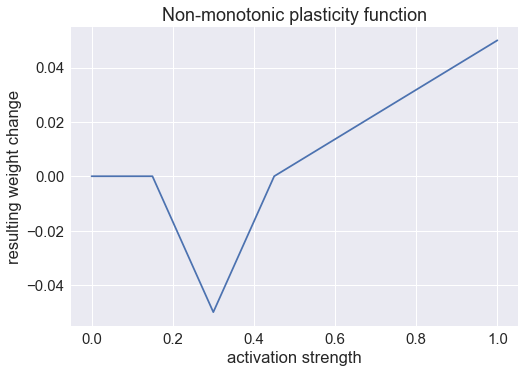

In [522]:
xs = np.linspace(0, 1., 101)
ys = xcal(xs)
plt.plot(xs, ys)
plt.xlabel('activation strength')
plt.ylabel('resulting weight change')
plt.title('Non-monotonic plasticity function')

Note that the positions of the inflection points in the NMPH equation are only meaningful relative to what counts as a "strong" connection weight in a specific adjacency matrix. Here we've plotted an NMPH function where the apple -> coconut connection is in the "zone of destruction."

We need to make sure our graph uses the correct re-weighting function (we'll use the same function plotted above).

In [523]:
fruit_graph_w2v.set_xcal(
    dip_center=.3,
    dip_width=.3,
    min_adjust=-.05,
    max_adjust=.05
)


When a node on the graph is activated, the activation spreads and adjacency matrix weights are automatically adjusted.

Repeatedly activating a single node will:

- (First order) Strengthen its already-strong connections to other nodes
- (First order) Weaken its already-weak connections
- (Second order) Strengthen or weaken downstream connections from other nodes depending on whether the activity is strong _when it arrives_ at those nodes

What happens when we activate one node over and over again.

In [524]:
for _ in range(10):
    fruit_graph_w2v.activate('apple')

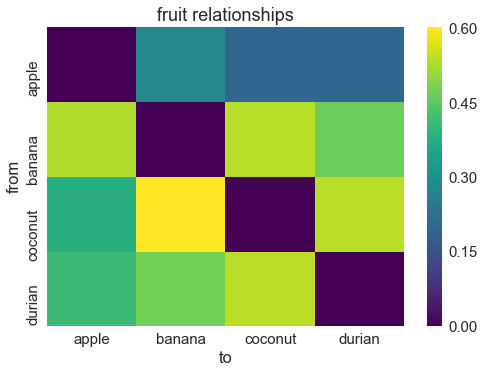

In [525]:
sns.heatmap(
    fruit_graph_w2v.adj, 
    xticklabels=fruit_graph_w2v.labels, 
    yticklabels=fruit_graph_w2v.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('fruit relationships')

### Replicating retrieval-induced forgetting results

This model captures the dynamics of retrieval-induced forgetting in cued retrieval practice, where category exemplars are associated with each other and also to a category label (e.g., Goodmon & Anderson, 2011).

In [538]:
goodmon_words = [
    'lion', 'tiger', 
    'horse', 'pony', 
    'walrus', 'seal', 
    'duck', 'goose',
    'lawyer', 'judge',
    'chef', 'baker',
    'nurse', 'doctor',
    'president', 'senator',
    'animal',
    'profession'
]

goodmon_dsm = sem.semantic_dsm(goodmon_words, google_news)
goodmon_graph = gsn.SemanticGraph(word_dsm=goodmon_dsm, labels=goodmon_words)

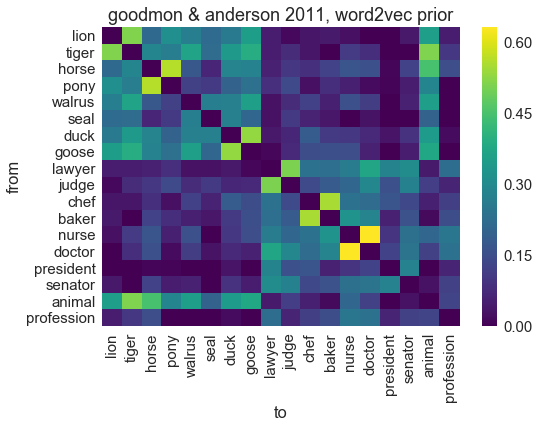

In [539]:
sns.heatmap(
    goodmon_graph.adj, 
    xticklabels=goodmon_graph.labels, 
    yticklabels=goodmon_graph.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('goodmon & anderson 2011, word2vec prior')

Items in this network are more distantly related than our fruits, so we'll use a slightly different NMPH re-weighting function. We'll also increase stronger connections more than we decrease weak ones.

In [540]:
goodmon_graph.set_xcal(
    dip_center=.2,
    dip_width=.2,
    min_adjust=-.05,
    max_adjust=.15
)

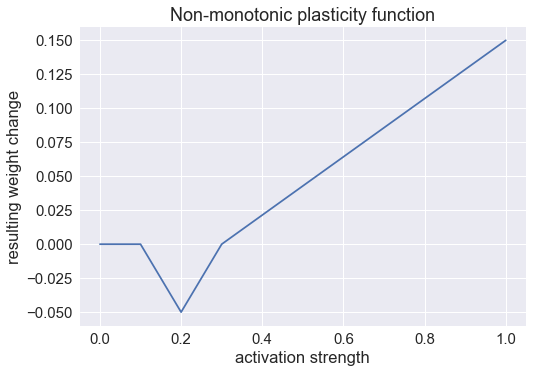

In [541]:
xs = np.linspace(0, 1., 101)
ys = goodmon_graph.xcal(xs)
plt.plot(xs, ys)
plt.xlabel('activation strength')
plt.ylabel('resulting weight change')
plt.title('Non-monotonic plasticity function')

This paradigm includes a **study** phase where exemplar words are associated with their category label (we assume this sets the weight to a value just above the zone of destruction).

In [542]:
# Study category-to-exemplar associations
goodmon_graph.adj[-2, 0:8] = goodmon_graph.xcal_dip_center + (goodmon_graph.xcal_dip_width / 2) + .15
goodmon_graph.adj[-1, 8:16] = goodmon_graph.xcal_dip_center + (goodmon_graph.xcal_dip_width / 2) + .15

# Study exemplar-to-category associations
# Make these weaker than the category-to-exemplar associations
# (This is plausible, and it prevents runaway behavior over many trials)
goodmon_graph.adj[0:8, -2] = goodmon_graph.xcal_dip_center + (goodmon_graph.xcal_dip_width / 2) + .11
goodmon_graph.adj[8:16, -1] = goodmon_graph.xcal_dip_center + (goodmon_graph.xcal_dip_width / 2) + .11

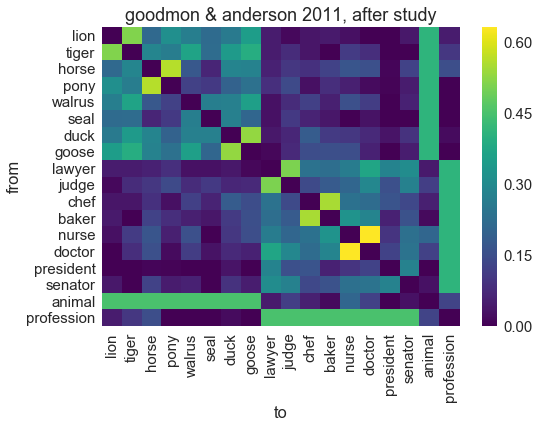

In [543]:
sns.heatmap(
    goodmon_graph.adj, 
    xticklabels=goodmon_graph.labels, 
    yticklabels=goodmon_graph.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('goodmon & anderson 2011, after study')

What happens when we practice cued recall on some—but not all—exemplar words from a category?

We implement cued recall as an activation of both the category label and the exemplar.

In [544]:
for _ in range(8):
    goodmon_graph.activate('animal')
    goodmon_graph.activate('lion')
    goodmon_graph.activate('animal')
    goodmon_graph.activate('horse')
    goodmon_graph.activate('animal')
    goodmon_graph.activate('walrus')
    goodmon_graph.activate('animal')
    goodmon_graph.activate('duck')

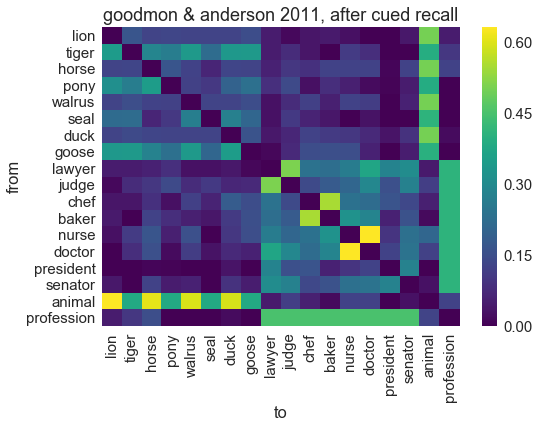

In [545]:
sns.heatmap(
    goodmon_graph.adj, 
    xticklabels=goodmon_graph.labels, 
    yticklabels=goodmon_graph.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')
plt.title('goodmon & anderson 2011, after cued recall')

We can see that inter-exemplar connections are weakened, and the category-to-exemplar connections are also weakened for within-category words where cued recall was not practiced (corresponding to decreased recall accuracy in Goodmon & Anderson's experiment).

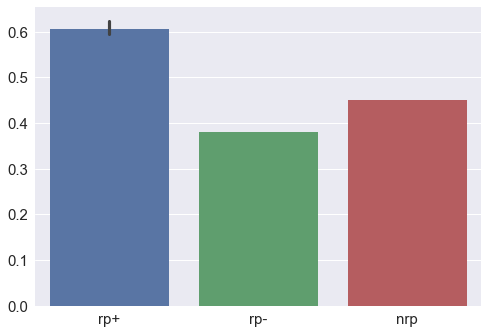

In [546]:
rp_plus = goodmon_graph.adj[-2, [0, 2, 4, 6]]
rp_minus = goodmon_graph.adj[-2, [1, 3, 5, 7]]
nrp = goodmon_graph.adj[-1, 8:16]

ax = sns.barplot(data=[rp_plus, rp_minus, nrp])
ax.set(xticklabels=['rp+', 'rp-', 'nrp']);